In [92]:
import os
import pickle

import numpy as np
import pandas as pd

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.models import model_from_yaml
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K

from keras.optimizers import SGD

from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image as kimage
from keras.callbacks import EarlyStopping
import sklearn.metrics as skmetrics

# Since default progress bars seem to crash Chrome
from keras_tqdm import TQDMNotebookCallback

import matplotlib.pyplot as plt
%matplotlib inline

# Part 1: Pre-trained Model with Modifications

## Load training and validation images

In [93]:
train_dir = "data/posters_split/train/"
validation_dir = "data/posters_split/validation/"

In [94]:
train_filenames = os.listdir(train_dir)
n_train = len(train_filenames)

validation_filenames = os.listdir(validation_dir)
n_validation = len(validation_filenames)

In [95]:
# Load train images in arrays
images=[None]*n_train
X=[None]*n_train

for i, train_filename in enumerate(train_filenames):
    images[i] = kimage.load_img(train_dir + train_filename, target_size=(224, 224))
    X[i] = kimage.img_to_array(images[i])
    X[i] = np.expand_dims(X[i], axis=0)
    X[i] = preprocess_input(X[i]).reshape(224,224,3)  

In [96]:
# Load validation images in arrays
val_images=[None]*n_validation
val_X=[None]*n_validation

for i, validation_filename in enumerate(validation_filenames):
    val_images[i] = kimage.load_img(validation_dir + validation_filename, target_size=(224, 224))
    val_X[i] = kimage.img_to_array(val_images[i])
    val_X[i] = np.expand_dims(val_X[i], axis=0)
    val_X[i] = preprocess_input(val_X[i]).reshape(224,224,3)  

## Load binary encoded response vectors for train and validation datasets

In [81]:
train_multilabels = pd.read_csv("data/train_labels.csv", index_col=0)
val_multilabels = pd.read_csv("data/val_labels.csv", index_col=0)

In [82]:
# Index is TMDB id, 20 columns correspond to the genres
print train_multilabels.shape, val_multilabels.shape

(9108, 20) (1139, 20)


In [83]:
train_multilabels.head()

,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,History,Horror,Music,Mystery,Romance,Science_Fiction,TV_Movie,Thriller,War,Western
id,,,,,,,,,,,,,,,,,,,,
80,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
430780,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
7985,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
53157,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
43821,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
# Get ids for train and val datasets in order the images were loaded in
train_ids = [int(filename.split("-")[-1].split("_")[0]) for filename in train_filenames]
val_ids = [int(filename.split("-")[-1].split("_")[0]) for filename in validation_filenames]

assert(len(train_ids) == len(train_multilabels))
assert(len(val_ids) == len(val_multilabels))

# Reorder rows of multilabel dataframes based on the order the images were loaded in 
train_multilabels = train_multilabels.reindex(train_ids)
val_multilabels = val_multilabels.reindex(val_ids)

assert(list(train_multilabels.index) == train_ids)
assert(list(val_multilabels.index) == val_ids)

## Use pretrained CNN to extract bottleneck features

In [ ]:
# Get bottleneck features from pretrained VGG16 
pretrained_model = VGG16(include_top=False, weights='imagenet')

X = np.array(X)
val_X = np.array(val_X)
train_features = pretrained_model.predict(X)
val_features = pretrained_model.predict(val_X)

# Save bottleneck features
np.save(open('bottleneck_features_train.npy', 'w'), train_features)
# Save bottleneck features
np.save(open('bottleneck_features_validation.npy', 'w'), val_features)

## (Optional: Only if you have the bottleneck features and want to load them to save time)

In [64]:
# Load bottleneck features
train_features = np.load('bottleneck_features_train.npy')
val_features = np.load('bottleneck_features_validation.npy')

## Add a fully-connected layer on top and train on bottleneck features

In [11]:
# Train a small fully-connected model on the bottleneck features
model = Sequential()
model.add(Flatten(input_shape=train_features.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(train_multilabels.shape[1], activation='sigmoid'))

model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_features, train_multilabels.values,
          epochs=50,
          batch_size=16,
          validation_data=(val_features, val_multilabels.values),
          verbose=0,
          callbacks=[TQDMNotebookCallback()])
model.save_weights('bottleneck_fc_model.h5')

In [14]:
# serialize model to YAML
model_yaml = model.to_yaml()
with open("model.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)

In [19]:
# Get probability predictions for each of the classes
train_probs = model.predict_proba(train_features)
val_probs = model.predict_proba(val_features)

 928/1139 [=======================>......] - ETA: 0s

In [16]:
# save train and validation probabilities and actual values
np.save('train_probs.npy', np.array(train_probs))
np.save('val_probs.npy', np.array(val_probs))
np.save('train_multilabels.npy', np.array(train_multilabels))
np.save('val_multilabels.npy', np.array(val_multilabels))

## Optional: Load predictions and actual multilabels to save time

In [4]:
train_probs = np.load('train_probs.npy')
val_probs = np.load('val_probs.npy')
train_multilabels = np.load('train_multilabels.npy')
val_multilabels = np.load('val_multilabels.npy')

## Load model from yaml

In [5]:
yaml_file = open('model.yaml', 'r')
loaded_model_yaml = yaml_file.read()
yaml_file.close()
model = model_from_yaml(loaded_model_yaml)
# load weights into new model
model.load_weights("bottleneck_fc_model.h5")
model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

## Evaluation of performance

In [21]:
# once training is complete, let's see how well we have done
score = model.evaluate(train_features, train_multilabels, verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

score = model.evaluate(val_features, val_multilabels, verbose=0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

('Train loss:', 0.18411072846510246)
('Train accuracy:', 0.9083389733305719)
('Validation loss:', 0.44618129028993492)
('Validation accuracy:', 0.87159804339153502)


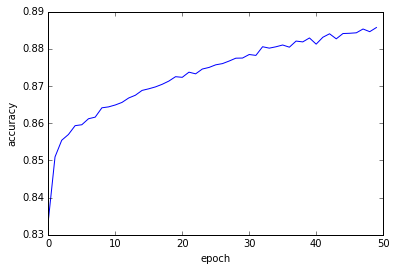

In [22]:
# here is a visualization of the training process
# typically we gain a lot in the beginning and then
# training slows down
plt.plot(history.history['acc'])
plt.xlabel("epoch")
plt.ylabel("accuracy")

In [40]:
# Find best threshold that results in highest exact match ratio in train
# for use on validation

# Range of threshold values to try
thresholds = np.arange(0.0,0.9,0.01)
accuracies = np.zeros(len(thresholds))

for t in range(len(thresholds)):
    accuracies[t] = skmetrics.accuracy_score(train_multilabels, np.array([[1 if train_probs[i][j] > thresholds[t] else 0 for j in range(train_probs.shape[1])] for i in range(len(train_probs))]))

# Find threshold that resulted in highest accuracy on train
best_threshold_index = np.argmax(accuracies)
best_threshold = thresholds[best_threshold_index]

print best_threshold

0.29


In [59]:
y_val = val_multilabels
y_pred_naive = np.array([[1 if val_probs[i][j] > 0.5 else 0 for j in range(val_probs.shape[1])] for i in range(len(val_probs))])

print 'Performance of CNN Predictions with Naive Thresholding'
print 'hamming loss:', skmetrics.hamming_loss(y_val, y_pred_naive)
print 'jaccard similarity:', skmetrics.jaccard_similarity_score(y_val, y_pred_naive)
print 'zero one loss:', skmetrics.zero_one_loss(y_val, y_pred_naive)
print 'exact match ratio:', skmetrics.accuracy_score(y_val, y_pred_naive)

Performance of CNN Predictions with Naive Thresholding
hamming loss: 0.128402107112
jaccard similarity: 0.146136962248
zero one loss: 0.962247585601
exact match ratio: 0.0377524143986


In [61]:
y_val = val_multilabels
y_thresholded_pred = np.array([[1 if val_probs[i][j] > best_threshold else 0 for j in range(val_probs.shape[1])] for i in range(len(val_probs))])

print 'Performance of CNN Predictions with Best Thresholding'
print 'hamming loss:', skmetrics.hamming_loss(y_val, y_thresholded_pred)
print 'jaccard similarity:', skmetrics.jaccard_similarity_score(y_val, y_thresholded_pred)
print 'zero one loss:', skmetrics.zero_one_loss(y_val, y_thresholded_pred)
print 'exact match ratio:', skmetrics.accuracy_score(y_val, y_thresholded_pred)

Performance of CNN Predictions with Best Thresholding
hamming loss: 0.160096575944
jaccard similarity: 0.254939283948
zero one loss: 0.963125548727
exact match ratio: 0.036874451273


Unfortunately, performance actually slightly degraded with our thresholding technique, but that was worth a shot.

## Sanity Check 
Since the results on exact match ratio for multilabel classification have been pretty disappointing so far, as a sanity check let's just choose the highest probability genre outputted from the predictions and see how often that genre is contained in the true multilabel for each movie.

In [60]:
# Get list of indices most likely genre per movie based on highest probability
most_likely_genre_per_movie = val_probs.argmax(axis=1)
# List of binary indicators for whether most likely genre is in the actual multilabel for each movie
genre_matches = [0 for i in range(len(most_likely_genre_per_movie))]

for i in range(len(most_likely_genre_per_movie)):
    genre_matches[i] = val_multilabels[i][most_likely_genre_per_movie[i]]

print "Accuracy in picking a correct genre:", np.mean(genre_matches)

Accuracy in picking a correct genre: 0.498683055312


Though this is a slightly relaxed (and easier task), it looks like our neural net is picking up a decent amount of signal, so we appear to be on the right track.

# Part 2: Fine-tuning the top layer
Now let's try to boost performance further by fine-tuning the last convolutional block.

In [ ]:
# Build the VGG16 network
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))

# Set up classifier on top of convolutional layers
top_model = Sequential()
top_model.add(Flatten(input_shape=train_features.shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(train_multilabels.shape[1], activation='sigmoid'))

# Load weights from previous training
top_model.load_weights("bottleneck_fc_model.h5")

# Add the model on top of the convolutional base
vgg16_model = Model(inputs=base_model.input, outputs=top_model(base_model.output))

# Freeze all convolutional layers up to the last convolutional block
for layer in vgg16_model.layers[:15]:
    layer.trainable = False

# Compile the model with a SGD
# and a very slow learning rate.
vgg16_model.compile(loss='binary_crossentropy',
              optimizer=SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

# Fit the model
fine_tune_history = vgg16_model.fit(np.array(X), train_multilabels.values,
            epochs=50,
            batch_size=16,
            validation_data=(np.array(val_X), val_multilabels.values),
            verbose=0,
            callbacks=[TQDMNotebookCallback()])

vgg16_model.save_weights('fine_tune_model.h5')

9104/|/[loss: 0.256, acc: 0.888] 100%|| 9104/9108 [03:40<00:00, 45.39it/s]

9104/|/[loss: 0.251, acc: 0.889] 100%|| 9104/9108 [03:34<00:00, 45.28it/s]

9104/|/[loss: 0.250, acc: 0.889] 100%|| 9104/9108 [03:32<00:00, 45.17it/s]

9104/|/[loss: 0.247, acc: 0.889] 100%|| 9104/9108 [03:39<00:00, 44.95it/s]

9104/|/[loss: 0.246, acc: 0.890] 100%|| 9104/9108 [03:37<00:00, 45.18it/s]

9104/|/[loss: 0.247, acc: 0.889] 100%|| 9104/9108 [03:34<00:00, 45.10it/s]

9104/|/[loss: 0.245, acc: 0.890] 100%|| 9104/9108 [03:32<00:00, 45.28it/s]

9104/|/[loss: 0.245, acc: 0.890] 100%|| 9104/9108 [03:40<00:00, 45.36it/s]

9104/|/[loss: 0.244, acc: 0.890] 100%|| 9104/9108 [03:38<00:00, 45.40it/s]

9104/|/[loss: 0.242, acc: 0.891] 100%|| 9104/9108 [03:35<00:00, 45.25it/s]

9104/|/[loss: 0.243, acc: 0.890] 100%|| 9104/9108 [03:33<00:00, 45.39it/s]

9104/|/[loss: 0.243, acc: 0.890] 100%|| 9104/9108 [03:40<00:00, 45.26it/s]

9104/|/[loss: 0.241, acc: 0.891] 100%|| 9104/9108 [03:38<00:00, 45.32it/s]

9104/|/[loss: 0.241, acc: 0.891] 100%|| 9104/9108 [03:35<00:00, 45.33it/s]

9104/|/[loss: 0.241, acc: 0.891] 100%|| 9104/9108 [03:33<00:00, 45.31it/s]

9104/|/[loss: 0.237, acc: 0.892] 100%|| 9104/9108 [03:40<00:00, 45.23it/s]

9104/|/[loss: 0.238, acc: 0.892] 100%|| 9104/9108 [03:38<00:00, 45.09it/s]

9104/|/[loss: 0.238, acc: 0.893] 100%|| 9104/9108 [03:35<00:00, 45.42it/s]